In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import itertools

In [2]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

## Age based SEIRS

### Import model

In [3]:
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected

### Define model locally

### Test model

In [4]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()

In [5]:
h = np.array([0.0205,0.0205,0.1755,0.1755,0.2115,0.2503,0.3066,0.4033,0.4770])
icu = np.array([0,0,0.0310,0.0310,0.055,0.077,0.107,0.1685,0.1895])
r = icu/h

In [6]:
# ... parameters and initial conditions
levels = initN.size
nc = Nc_total
params = parameters.get_COVID19_SEIRD_parameters()

initial_states = {'S': initN, 'E': np.ones(levels)}

In [7]:
# -> user initiates the model
sir_model = models.COVID19_SEIRD(initial_states, params)

# -> user runs a simulation for a defined time period
time = [0, 200]
output = sir_model.sim(time)

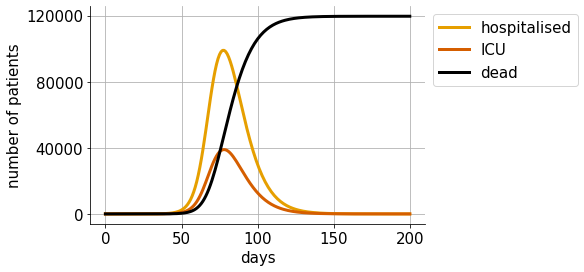

In [8]:
infected(output)

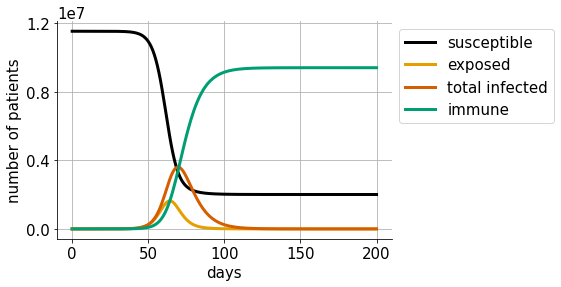

In [9]:
population_status(output)

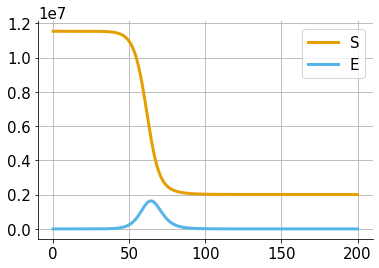

In [10]:
plt.plot(output.coords['time'], output['S'].sum(dim="stratification"), label="S")
plt.plot(output.coords['time'], output['E'].sum(dim="stratification"), label="E")

plt.legend()

In [11]:
from covid19model.data import sciensano

In [12]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.head()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum
DATE,,,,,
2020-03-15,266,54,71,18,53
2020-03-16,370,79,90,14,129
2020-03-17,497,100,123,31,221
2020-03-18,650,131,183,48,356
2020-03-19,844,165,212,49,519


Convert the data to a xarray DataArray (can be later extended towards xarray Dataset if multiple states are compared

In [13]:
data_to_fit = xr.DataArray([ 54,  79, 100, 131, 165, 228, 290], 
                           coords={"time": range(1, 8)}, name="ICU",
                           dims=['time'])
data_to_fit

<xarray.DataArray 'ICU' (time: 7)>
array([ 54,  79, 100, 131, 165, 228, 290])
Coordinates:
  * time     (time) int64 1 2 3 4 5 6 7

In [14]:
data_to_fit.values

array([ 54,  79, 100, 131, 165, 228, 290])

In [15]:
from covid19model.optimization.objective_fcns import sse

Try out the sse function:

In [16]:
sse([0.3, 0.04, 12], sir_model, data_to_fit, ['sigma', 'beta'], lag_time=None)

122202.00118319865

In [17]:
sse([1.6, 0.025, 42], sir_model, data_to_fit, ['sigma', 'beta'], lag_time=None)

6437.4700475273885

Due to the setup of the function, this is similar to

In [18]:
sse([1.6, 0.025], sir_model, data_to_fit, ['sigma', 'beta'], lag_time=42)

6437.4700475273885

Apply with fixed lag time:

In [19]:
sse([1.6, 0.025], sir_model, data_to_fit, ['sigma', 'beta'], lag_time=40)

13328.779260868365

Apply the optimization pso functionality:

In [20]:
import multiprocessing as mp
from covid19model.optimization import pso

In [21]:
from covid19model.optimization.optimize import fit

In [27]:
bounds=[(1, 100), (0.02, 0.06), (20, 80)]

In [28]:
fit(sse, sir_model, data_to_fit, ['sigma', 'beta'], bounds)

No constraints given.
New best for swarm at iteration 1: [ 1.          0.03304964 24.70556363] 10807.146214163115
Best after iteration 1: [ 1.          0.03304964 24.70556363] 10807.146214163115
Best after iteration 2: [ 1.          0.03304964 24.70556363] 10807.146214163115
Best after iteration 3: [ 1.          0.03304964 24.70556363] 10807.146214163115
Best after iteration 4: [ 1.          0.03304964 24.70556363] 10807.146214163115
New best for swarm at iteration 5: [ 1.          0.03285257 25.5069565 ] 1016.6487860669702
Best after iteration 5: [ 1.          0.03285257 25.5069565 ] 1016.6487860669702
Best after iteration 6: [ 1.          0.03285257 25.5069565 ] 1016.6487860669702
Best after iteration 7: [ 1.          0.03285257 25.5069565 ] 1016.6487860669702
Best after iteration 8: [ 1.          0.03285257 25.5069565 ] 1016.6487860669702
Best after iteration 9: [ 1.          0.03285257 25.5069565 ] 1016.6487860669702
Best after iteration 10: [ 1.          0.03285257 25.5069565 ] 10

array([ 1.        ,  0.03279307, 25.75214352])